In [25]:
# =====================================
# GDP Per Capita Modeling & Feature Importance
# =====================================
import pandas as pd
import numpy as np

In [26]:
# -----------------------------
# 1. Load and prepare data
# -----------------------------

# Load base dataset
df_path = "../data/clean_data.csv"
df = pd.read_csv(df_path).drop(["Unnamed: 0"], axis=1)

# Sort for consistent year ordering within each country
df = df.sort_values(["alpha_2", "year"]).copy()

# Compute relative (percent) change year-over-year
df["gdp_growth"] = df.groupby("alpha_2")["GDP"].pct_change() * 100
df["population_growth"] = df.groupby("alpha_2")["population"].pct_change() * 100

# Drop rows without previous-year data (first year per country)
df.dropna(subset=["gdp_growth", "population_growth"], inplace=True)

# Remove absolute level columns, keeping only growth-based variables
df.drop(["population", "GDP"], axis=1, inplace=True)

print("Data shape after processing:", df.shape)


Data shape after processing: (8249, 14)


In [27]:
# -----------------------------
# 2. Split data by country
# -----------------------------

# Target column
TARGET = "gdp_growth"

# Get unique countries
countries = df["alpha_2"].unique()
np.random.seed(42)  # for reproducibility
np.random.shuffle(countries)

# Split indices (70/15/15)
n = len(countries)
train_countries = countries[: int(0.7 * n)]
val_countries   = countries[int(0.7 * n) : int(0.85 * n)]
test_countries  = countries[int(0.85 * n) :]

# Assign masks
train_mask = df["alpha_2"].isin(train_countries)
val_mask   = df["alpha_2"].isin(val_countries)
test_mask  = df["alpha_2"].isin(test_countries)

# Create subsets
train_df = df[train_mask].copy()
val_df   = df[val_mask].copy()
test_df  = df[test_mask].copy()

print(f"Train countries: {len(train_countries)} | "
      f"Val: {len(val_countries)} | "
      f"Test: {len(test_countries)}")

print(f"Train rows: {train_df.shape[0]} | "
      f"Val: {val_df.shape[0]} | "
      f"Test: {test_df.shape[0]}")


Train countries: 107 | Val: 23 | Test: 24
Train rows: 5770 | Val: 1293 | Test: 1186


In [28]:
# -----------------------------
# 3. Define features and target
# -----------------------------

# Target variable: GDP growth (% change from previous year)
TARGET = "gdp_growth"

# Predictor features (all lag-insensitive indicators)
features = [
    "population_growth",
    "life_expectancy",
    "net_migration",
    "internet_users_pct",
    "human_capital_index",
    "school_enroll_secondary_gpi",
    "urban_population_pct",
    "infant_mortality_rate",
    "female_population_pct",
    "male_population_pct",
]

# Split predictors and target for each subset
X_train = train_df[features]
y_train = train_df[TARGET]

X_val = val_df[features]
y_val = val_df[TARGET]

X_test = test_df[features]
y_test = test_df[TARGET]

print("Feature matrix shapes:")
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Feature matrix shapes:
Train: (5770, 10), Validation: (1293, 10), Test: (1186, 10)


In [29]:
# -----------------------------
# 4. Build Random Forest model
# -----------------------------
from sklearn.ensemble import RandomForestRegressor

# Initialize Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,      # number of trees
    max_depth=None,        # let trees grow fully (can tune later)
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",   # good default for regression
    n_jobs=-1,             # use all CPU cores
    random_state=42
)

print("Random Forest model initialized.")


Random Forest model initialized.


In [ ]:
# -----------------------------
# 5. Fit model
# -----------------------------

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)
print("Done!")


Training Random Forest model...
Done!
Model performance (original GDP scale):
LinearReg  | RMSE: 38,167,107,568,876.73 | R²: -5896235701121774379859968.000

Validation performance:
RMSE: 528.47
R²: -0.027


In [35]:
# -----------------------------
# 6. Evaluate model performance
# -----------------------------
import numpy as np
from sklearn.metrics import r2_score

# Prefer the dedicated RMSE function
try:
    from sklearn.metrics import root_mean_squared_error as rmse
except ImportError:
    # Fallback for older sklearn: compute RMSE manually
    from sklearn.metrics import mean_squared_error
    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

# --- Validation ---
val_preds = rf_model.predict(X_val)
val_rmse = rmse(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)
print("\nValidation performance:")
print(f"RMSE: {val_rmse:,.2f}")
print(f"R²:   {val_r2:.3f}")

# --- Test ---
test_preds = rf_model.predict(X_test)
test_rmse = rmse(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)
print("\nTest performance:")
print(f"RMSE: {test_rmse:,.2f}")
print(f"R²:   {test_r2:.3f}")



Validation performance:
RMSE: 22.99
R²:   -0.027

Test performance:
RMSE: 15.73
R²:   -0.002


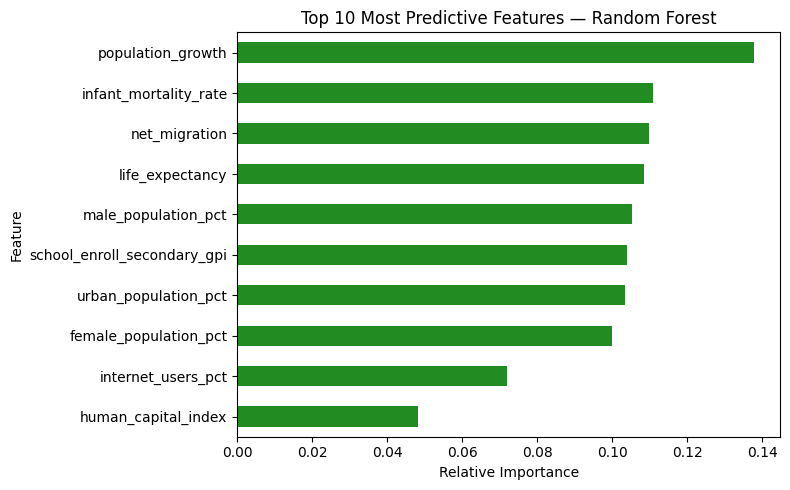


Feature importances (descending):
population_growth              0.1379
infant_mortality_rate          0.1109
net_migration                  0.1099
life_expectancy                0.1085
male_population_pct            0.1053
school_enroll_secondary_gpi    0.1040
urban_population_pct           0.1034
female_population_pct          0.0999
internet_users_pct             0.0720
human_capital_index            0.0483
dtype: float64


In [36]:
# -----------------------------
# 7. Feature importance
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances
importances = pd.Series(rf_model.feature_importances_, index=features)
importances = importances.sort_values(ascending=True)

# --- Plot top features ---
plt.figure(figsize=(8, 5))
importances.tail(10).plot(kind="barh", color="forestgreen")
plt.title("Top 10 Most Predictive Features — Random Forest")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Print full ranking ---
print("\nFeature importances (descending):")
print(importances.sort_values(ascending=False).round(4))


In [37]:
# -----------------------------
# 8. Smooth target variable (3-year rolling average)
# -----------------------------
import pandas as pd

# Sort by country and year to ensure correct rolling order
df = df.sort_values(["alpha_2", "year"]).copy()

# Compute 3-year rolling mean of GDP growth within each country
df["gdp_growth_3yr"] = (
    df.groupby("alpha_2")["gdp_growth"]
      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

print("Rolling average created — new column: 'gdp_growth_3yr'")


Rolling average created — new column: 'gdp_growth_3yr'


In [38]:
# -----------------------------
# 9. Redefine target and splits
# -----------------------------
TARGET = "gdp_growth_3yr"

X_train = train_df[features]
y_train = train_df.merge(df[["alpha_2", "year", TARGET]], on=["alpha_2", "year"], how="left")[TARGET]

X_val = val_df[features]
y_val = val_df.merge(df[["alpha_2", "year", TARGET]], on=["alpha_2", "year"], how="left")[TARGET]

X_test = test_df[features]
y_test = test_df.merge(df[["alpha_2", "year", TARGET]], on=["alpha_2", "year"], how="left")[TARGET]

print(f"Using smoothed target: {TARGET}")


Using smoothed target: gdp_growth_3yr


In [39]:
# -----------------------------
# 10. Retrain Random Forest on smoothed target
# -----------------------------
rf_model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import root_mean_squared_error, r2_score

val_preds = rf_model.predict(X_val)
val_rmse = root_mean_squared_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

test_preds = rf_model.predict(X_test)
test_rmse = root_mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print("\nValidation performance (3-year smoothed):")
print(f"RMSE: {val_rmse:,.2f}")
print(f"R²:   {val_r2:.3f}")

print("\nTest performance (3-year smoothed):")
print(f"RMSE: {test_rmse:,.2f}")
print(f"R²:   {test_r2:.3f}")



Validation performance (3-year smoothed):
RMSE: 14.89
R²:   -0.027

Test performance (3-year smoothed):
RMSE: 10.34
R²:   0.035


In [ ]:
# -----------------------------
# 7. Feature importance
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt

# Extract feature importances
importances = pd.Series(rf_model.feature_importances_, index=features)
importances = importances.sort_values(ascending=True)

# --- Plot top features ---
plt.figure(figsize=(8, 5))
importances.tail(10).plot(kind="barh", color="forestgreen")
plt.title("Top 10 Most Predictive Features — Random Forest")
plt.xlabel("Relative Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# --- Print full ranking ---
print("\nFeature importances (descending):")
print(importances.sort_values(ascending=False).round(4))
